In [1]:
''' RNN Bidireccional en Keras '''
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, Dense, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
print('Train: (examples, x pixels, y pixels):\n{}\nTest: (examples, x pixels y pixels):\n{}'.format(x_train.shape, x_test.shape))

Train: (examples, x pixels, y pixels):
(60000, 28, 28)
Test: (examples, x pixels y pixels):
(10000, 28, 28)


In [4]:
x_train = x_train/255
x_test = x_test/255
x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_test = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))
print('Train new shape: {}\nTest new shape:{}'.format(x_train.shape, x_test.shape))

Train new shape: (60000, 784)
Test new shape:(10000, 784)


## Autoencoder:

In [5]:
encoding_dim = 36
input_img = Input(shape=(x_train.shape[1],))
encoder = Dense(encoding_dim, activation='relu')(input_img)
decoder = Dense(x_train.shape[1], activation='sigmoid')(encoder)
autoencoder = Model(input_img, decoder) # maps de inputs with the decoder

In [6]:
# Encoder:
encoder = Model(input_img, encoder)
encoder_input = Input(shape=(encoding_dim,))
# Decoder:
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoder_input, decoder_layer(encoder_input))

In [7]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [8]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 36)                28260     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               29008     
Total params: 57,268
Trainable params: 57,268
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 74us/step - loss: 0.3538 - val_loss: 0.2713
Epoch 2/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.2645 - val_loss: 0.2538
Epoch 3/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.2426 - val_loss: 0.2292
Epoch 4/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.2217 - val_loss: 0.2118
Epoch 5/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.2069 - val_loss: 0.1992
Epoch 6/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.1960 - val_loss: 0.1899
Epoch 7/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.1876 - val_loss: 0.1825
Epoch 8/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.1807 - val_loss: 0.1760
Epoch 9/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.1745 - val_loss: 0.1

In [10]:
encoder_imgs = encoder.predict(x_test)
decoder_imgs = decoder.predict(encoder_imgs)

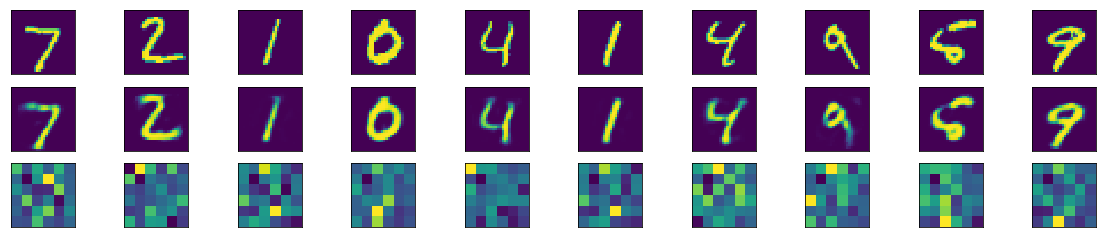

In [11]:
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(3, 10, i+1)
    ax.imshow(x_test[i].reshape(28, 28))
    plt.xticks(())
    plt.yticks(())
    ax2 = plt.subplot(3, 10, i + 1 + 10)
    ax2.imshow(decoder_imgs[i].reshape(28, 28))
    plt.xticks(())
    plt.yticks(())
    ax3 = plt.subplot(3, 10, i + 1 + 2*10)
    ax3.imshow(encoder_imgs[i].reshape(6, 6))
    plt.xticks(())
    plt.yticks(())

In [12]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

Text(0.5,0,'epochs')

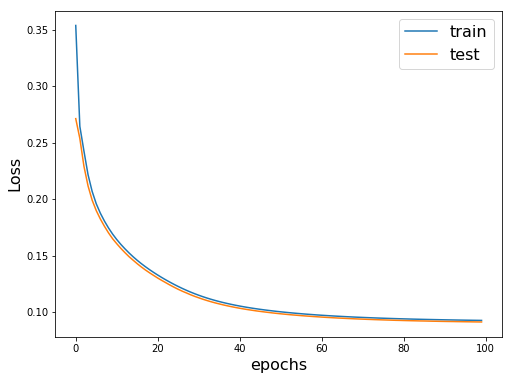

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend(fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel('epochs', fontsize=16)

## Deep autoencoders

In [14]:
encoding_dim = 128
x_train.shape

(60000, 784)

In [15]:
input_img = Input(shape=(x_train.shape[1],))
encoder = Dense(encoding_dim, activation='relu')(input_img)
encoder = Dense(int(encoding_dim/2), activation='relu')(encoder)
encoder = Dense(int(encoding_dim/4), activation='relu')(encoder)
decoder = Dense(int(encoding_dim/2), activation='relu')(encoder)
decoder = Dense(int(encoding_dim), activation='relu')(decoder)
decoder = Dense(x_train.shape[1], activation='sigmoid')(decoder)
autoencoder = Model(input_img, decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 784)               101136    
Total para

In [16]:
best_model_path = 'best_deep_Aencoder.hdf5'
checkpoint = ModelCheckpoint(best_model_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['acc', 'mse'])
history = autoencoder.fit(x_train, x_train, epochs=40, batch_size=256, shuffle=True, callbacks=[checkpoint],
                          validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 3s 44us/step - loss: 0.3367 - acc: 0.7507 - mean_squared_error: 0.0939 - val_loss: 0.2620 - val_acc: 0.7906 - val_mean_squared_error: 0.0671

Epoch 00001: val_acc improved from -inf to 0.79059, saving model to best_deep_Aencoder.hdf5
Epoch 2/40
60000/60000 [==============================] - 2s 30us/step - loss: 0.2558 - acc: 0.7955 - mean_squared_error: 0.0650 - val_loss: 0.2442 - val_acc: 0.7956 - val_mean_squared_error: 0.0611

Epoch 00002: val_acc improved from 0.79059 to 0.79561, saving model to best_deep_Aencoder.hdf5
Epoch 3/40
60000/60000 [==============================] - 2s 28us/step - loss: 0.2320 - acc: 0.7928 - mean_squared_error: 0.0569 - val_loss: 0.2228 - val_acc: 0.7967 - val_mean_squared_error: 0.0543

Epoch 00003: val_acc improved from 0.79561 to 0.79666, saving model to best_deep_Aencoder.hdf5
Epoch 4/40
60000/60000 [==============================] - 2s 28us/st


Epoch 00032: val_acc did not improve
Epoch 33/40
60000/60000 [==============================] - 2s 30us/step - loss: 0.1256 - acc: 0.8096 - mean_squared_error: 0.0208 - val_loss: 0.1228 - val_acc: 0.8090 - val_mean_squared_error: 0.0199

Epoch 00033: val_acc did not improve
Epoch 34/40
60000/60000 [==============================] - 2s 28us/step - loss: 0.1246 - acc: 0.8097 - mean_squared_error: 0.0204 - val_loss: 0.1220 - val_acc: 0.8094 - val_mean_squared_error: 0.0197

Epoch 00034: val_acc did not improve
Epoch 35/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.1238 - acc: 0.8099 - mean_squared_error: 0.0202 - val_loss: 0.1214 - val_acc: 0.8099 - val_mean_squared_error: 0.0194

Epoch 00035: val_acc improved from 0.80968 to 0.80992, saving model to best_deep_Aencoder.hdf5
Epoch 36/40
60000/60000 [==============================] - 2s 28us/step - loss: 0.1227 - acc: 0.8101 - mean_squared_error: 0.0198 - val_loss: 0.1198 - val_acc: 0.8097 - val_mean_squared_erro

In [17]:
model = load_model(best_model_path)
encoder = Model(model.layers[0].input, model.layers[2].output)
encoder_imgs = encoder.predict(x_test)
decoder_imgs = model.predict(x_test)

Text(0.5,0,'epochs')

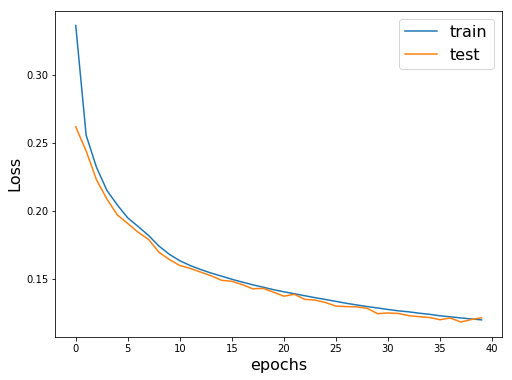

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend(fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel('epochs', fontsize=16)

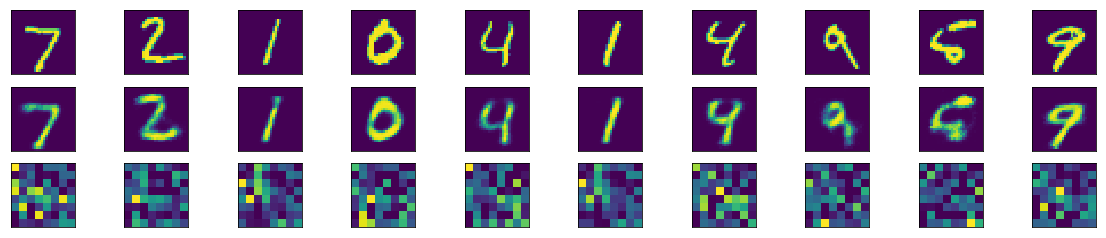

In [19]:
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(3, 10, i+1)
    ax.imshow(x_test[i].reshape(28, 28))
    plt.xticks(())
    plt.yticks(())
    ax2 = plt.subplot(3, 10, i + 1 + 10)
    ax2.imshow(decoder_imgs[i].reshape(28, 28))
    plt.xticks(())
    plt.yticks(())
    ax3 = plt.subplot(3, 10, i + 1 + 2*10)
    ax3.imshow(encoder_imgs[i].reshape(8, 8))
    plt.xticks(())
    plt.yticks(())

## Deep Convolutional autoencoders:

In [20]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('Train: (examples, x pixels, y pixels):\n{}\nTest: (examples, x pixels y pixels):\n{}'.format(x_train.shape, x_test.shape))

Train: (examples, x pixels, y pixels):
(60000, 28, 28)
Test: (examples, x pixels y pixels):
(10000, 28, 28)


In [21]:
x_train = x_train/255
x_test = x_test/255
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Train new shape: {}\nTest new shape:{}'.format(x_train.shape, x_test.shape))

Train new shape: (60000, 28, 28, 1)
Test new shape:(10000, 28, 28, 1)


In [22]:
input_img = Input(shape=x_train.shape[1:])
encoder = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
encoder = MaxPooling2D((2,2), padding='same')(encoder)
encoder = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2,2), padding='same')(encoder)
encoder = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2,2), padding='same')(encoder)

decoder = Conv2D(8, (3,3), activation='relu', padding='same')(encoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(8, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(16, (3, 3), activation='relu')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)

autoencoder = Model(input_img, decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [23]:
best_model_path = 'best_convolutional_Aencoder.hdf5'
checkpoint = ModelCheckpoint(best_model_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['acc', 'mse'])
history = autoencoder.fit(x_train, x_train, epochs=40, batch_size=256, shuffle=False, callbacks=[checkpoint],
                          validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 5s 80us/step - loss: 0.2376 - acc: 0.7947 - mean_squared_error: 0.0595 - val_loss: 0.1873 - val_acc: 0.7973 - val_mean_squared_error: 0.0432

Epoch 00001: val_acc improved from -inf to 0.79734, saving model to best_convolutional_Aencoder.hdf5
Epoch 2/40
60000/60000 [==============================] - 3s 45us/step - loss: 0.1695 - acc: 0.7954 - mean_squared_error: 0.0372 - val_loss: 0.1790 - val_acc: 0.8049 - val_mean_squared_error: 0.0400

Epoch 00002: val_acc improved from 0.79734 to 0.80493, saving model to best_convolutional_Aencoder.hdf5
Epoch 3/40
60000/60000 [==============================] - 3s 46us/step - loss: 0.1544 - acc: 0.7993 - mean_squared_error: 0.0317 - val_loss: 0.1521 - val_acc: 0.8049 - val_mean_squared_error: 0.0306

Epoch 00003: val_acc did not improve
Epoch 4/40
60000/60000 [==============================] - 3s 46us/step - loss: 0.1453 - acc: 0.8016 - mean_s

In [24]:
model = load_model('best_convolutional_Aencoder.hdf5')
encoder = Model(model.layers[0].input, model.layers[5].output)
encoder_imgs = encoder.predict(x_test)
decoder_imgs = model.predict(x_test)
encoder_imgs.shape

(10000, 7, 7, 8)

Text(0.5,0,'epochs')

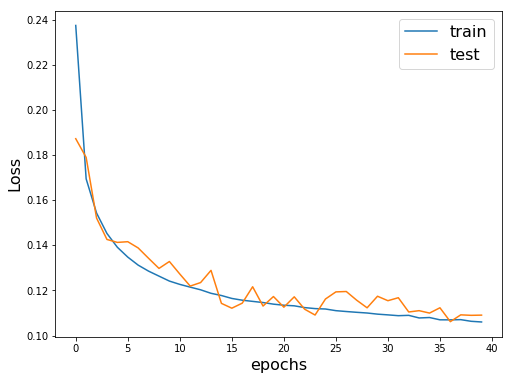

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend(fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel('epochs', fontsize=16)

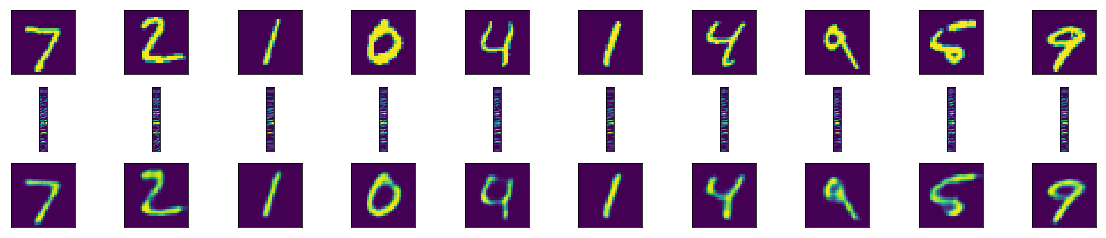

In [26]:
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(3, 10, i+1)
    ax.imshow(x_test[i].reshape(28, 28))
    plt.xticks(())
    plt.yticks(())
    ax2 = plt.subplot(3, 10, i + 1 + 10)
    ax2.imshow(encoder_imgs[i].reshape(7, 7*8).T)
    plt.xticks(())
    plt.yticks(())
    ax3 = plt.subplot(3, 10, i + 1 + 2*10)
    ax3.imshow(decoder_imgs[i].reshape(28, 28))
    plt.xticks(())
    plt.yticks(())

In [27]:
y_test2 = to_categorical(y_test, 10)
y_train2 = to_categorical(y_train, 10)
encoder_train = encoder.predict(x_train)
encoder_test = encoder.predict(x_test)

In [28]:
encoder_train = encoder_train.reshape(encoder_train.shape[0], 7, 8*7, 1)
encoder_test = encoder_test.reshape(encoder_test.shape[0], 7, 8*7, 1)
encoder_train.shape

(60000, 7, 56, 1)

In [29]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=encoder_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 5, 54, 32)         320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 52, 64)         18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 26, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1664)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               213120    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 233,226
Trainable params: 233,226
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
history = model.fit(encoder_train, y_train2, batch_size=256, epochs=40, validation_data=(encoder_test, y_test2))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 3s 42us/step - loss: 0.5336 - acc: 0.8328 - val_loss: 0.2175 - val_acc: 0.9304
Epoch 2/40
60000/60000 [==============================] - 2s 28us/step - loss: 0.1382 - acc: 0.9564 - val_loss: 0.1042 - val_acc: 0.9662
Epoch 3/40
60000/60000 [==============================] - 2s 27us/step - loss: 0.0961 - acc: 0.9691 - val_loss: 0.1200 - val_acc: 0.9636
Epoch 4/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.0763 - acc: 0.9758 - val_loss: 0.0713 - val_acc: 0.9763
Epoch 5/40
60000/60000 [==============================] - 2s 28us/step - loss: 0.0629 - acc: 0.9802 - val_loss: 0.0935 - val_acc: 0.9712
Epoch 6/40
60000/60000 [==============================] - 2s 28us/step - loss: 0.0534 - acc: 0.9829 - val_loss: 0.0587 - val_acc: 0.9799
Epoch 7/40
60000/60000 [==============================] - 2s 27us/step - loss: 0.0468 - acc: 0.9850 - val_loss: 0.0775 - val_acc

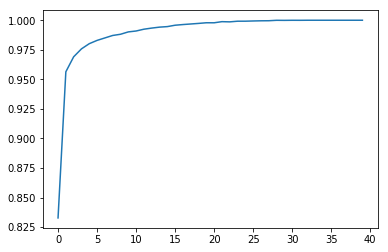

In [31]:
plt.plot(history.history['acc'])